In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import dpdata
import ase
from ase.io import read,write
import os
import matplotlib.pyplot as plt
from ase import Atoms
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
## Load the dataset
D_numpy=np.load('/ihome/kjohnson/pbs13/PhD/FLOSIC/Python/DP_FLOSIC/H2O_perturbFOD.03/D.npy')[:,0,:] # Shape: (#datapoints X SOAP centers X features)
                                                                                                    # [:,0,:]: (#datapoints X #features)    
# print(D_numpy)
# print(D_numpy.shape)
n_samples,n_features=D_numpy.shape
print(f"Number of samples: {n_samples}, Number of features: {n_features} ")

E_numpy=np.array([np.load('/ihome/kjohnson/pbs13/PhD/FLOSIC/Python/DP_FLOSIC/H2O_perturbFOD.03/E.npy')]).T
print("Energy shape: ",E_numpy.shape)

F_numpy=np.load('/ihome/kjohnson/pbs13/PhD/FLOSIC/Python/DP_FLOSIC/H2O_perturbFOD.03/F.npy')
print("Force shape: ",F_numpy.shape)

dD_dr_numpy=np.load('/ihome/kjohnson/pbs13/PhD/FLOSIC/Python/DP_FLOSIC/H2O_perturbFOD.03/dD_dr.npy')[:,0,:,:,:] #Only 1 SOAP center
print('SOAP derivatives shape: ',dD_dr_numpy.shape)

r_numpy=np.load('/ihome/kjohnson/pbs13/PhD/FLOSIC/Python/DP_FLOSIC/H2O_perturbFOD.03/r.npy')
print('r shape: ',r_numpy.shape)


Number of samples: 200, Number of features: 147 
Energy shape:  (200, 1)
Force shape:  (200, 5, 3)
SOAP derivatives shape:  (200, 5, 3, 147)
r shape:  (200,)


In [3]:
## Scaling is applied to energy, descriptors and derivatives on training and testing

scaler=StandardScaler()
scaler.fit(D_numpy)
D_numpy_whole_scale=scaler.transform(D_numpy)

# print(D_numpy)
# print(D_numpy_whole_scale)
# plt.plot(D_numpy_whole_scale);
# plt.show()
# plt.plot(D_numpy);

scaler.fit(D_numpy)
dD_dr_numpy_whole_scale=dD_dr_numpy/scaler.scale_[None,None,None,:]
# print(dD_dr_numpy_whole_scale[0].shape)
# print(dD_dr_numpy_whole_scale[0])
# print("No scale: ",dD_dr_numpy[0])


minmaxscaler=MinMaxScaler()
minmaxscaler.fit(E_numpy)
E_numpy_whole=minmaxscaler.transform(E_numpy)

print(D_numpy_whole_scale.shape)
print(dD_dr_numpy_whole_scale.shape)
print(F_numpy.shape)
E_numpy_whole.shape



(200, 324)
(200, 5, 3, 324)
(200, 5, 3)


(200, 1)

In [4]:
# Split data into train partition and test partition
D_numpy_train, D_numpy_test, E_numpy_train, E_numpy_test,F_numpy_train, F_numpy_test, dD_dr_numpy_train, dD_dr_numpy_test=train_test_split(
    D_numpy_whole_scale,E_numpy_whole,F_numpy,dD_dr_numpy_whole_scale,random_state=42,test_size=0.2)

In [16]:
print(D_numpy_train.shape)
print(E_numpy_train.shape)
print(dD_dr_numpy_train.shape)
print(F_numpy_train.shape)

(160, 324)
(160, 1)
(160, 5, 3, 324)
(160, 5, 3)


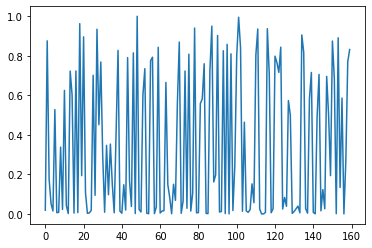

In [6]:
# E_numpy_train.astype('float')
# D_numpy_train.shape, 
plt.plot(E_numpy_train)
# E_numpy_train.T[0]

In [15]:
mlp=MLPRegressor(hidden_layer_sizes=(1400,1000,750,320, 150 ),verbose=False, tol=1e-10, learning_rate_init=0.0001, max_iter=1000)
mlp.fit(D_numpy_train,E_numpy_train.T[0])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1400, 1000, 750, 320, 150),
       learning_rate='constant', learning_rate_init=0.0001, max_iter=1000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=1e-10,
       validation_fraction=0.1, verbose=False, warm_start=False)

Text(0.5, 1.0, 'Training data')

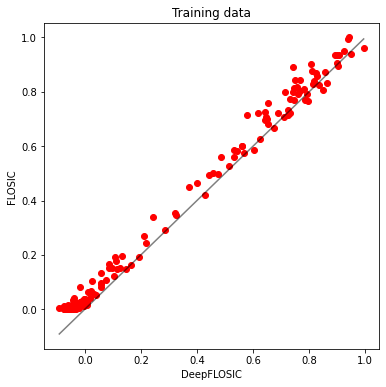

In [8]:
pred=mlp.predict(D_numpy_train)
plt.figure(figsize=(6,6))
plt.scatter(pred,E_numpy_train.T[0],color='r')
plt.plot(np.linspace(min(pred), max(pred)), np.linspace(min(pred), max(pred)), 'k-', alpha=0.5)
plt.xlabel('DeepFLOSIC')
plt.ylabel('FLOSIC')
plt.title('Training data')
plt.savefig()


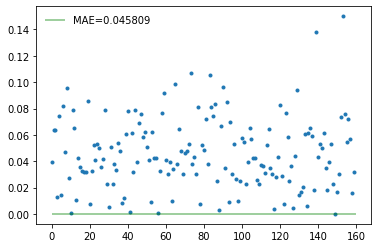

In [9]:
err = np.abs(pred-E_numpy_train.T[0])
plt.plot(err,'.')
plt.hlines(0, 160, np.mean(err),'g',alpha=0.5, label=f'MAE={np.mean(err):1.6f}')
plt.legend(frameon=False)

In [10]:
test_pred = mlp.predict(D_numpy_test)

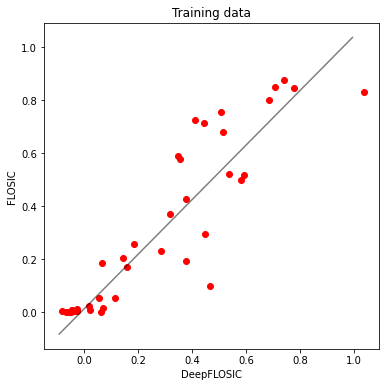

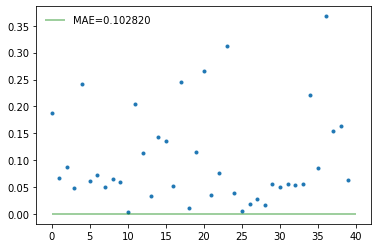

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(test_pred,E_numpy_test.T[0],color='r')
plt.plot(np.linspace(min(pred), max(pred)), np.linspace(min(test_pred), max(test_pred)), 'k-', alpha=0.5)
plt.xlabel('DeepFLOSIC')
plt.ylabel('FLOSIC')
plt.title('Testing data')
plt.show()
err_test = np.abs(test_pred-E_numpy_test.T[0])
plt.plot(err_test,'.')
plt.hlines(0, len(test_pred), np.mean(err_test),'g',alpha=0.5, label=f'MAE={np.mean(err_test):1.6f}')
plt.legend(frameon=False)